<a href="https://colab.research.google.com/github/tangani/New-York-City-Taxi-Fare-Prediction/blob/main/new_york_city_taxi_fare_prediction_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New York City Taxi Fare Prediction

### Aim: Predict the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations.



## Steps to be followd in this notebook:

*    Data Gathering
*    Exploritory data analysis
*    Testing the model’s performance
*    Implementing custom object detectors on test images
*    Loading the models and implementation 

### Import required libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

### Import data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/data_science/new-york-city-taxi-fare-prediction/train.csv', nrows=100000)
test_df = pd.read_csv('/content/drive/MyDrive/data_science/new-york-city-taxi-fare-prediction/test.csv')

### Take a look at the data structure

At this point we are mostly interested at the train set which is what we have to analyze and augment to prepare for the training model first

In [5]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [6]:
train_df.shape

(100000, 8)

In [7]:
test_df.shape

(9914, 7)

In [8]:
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


In [9]:
test_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                9914 non-null   object 
 1   pickup_datetime    9914 non-null   object 
 2   pickup_longitude   9914 non-null   float64
 3   pickup_latitude    9914 non-null   float64
 4   dropoff_longitude  9914 non-null   float64
 5   dropoff_latitude   9914 non-null   float64
 6   passenger_count    9914 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 542.3+ KB


In [12]:
longitude_nulls = len(train_df[train_df['dropoff_longitude'].isnull()])
latitude_nulls = len(train_df[train_df['dropoff_latitude'].isnull()])
print("There are {} dropoff_longitude values and {} dropoff_latitude values in the train dataframe".format(longitude_nulls, latitude_nulls))

There are 0 dropoff_longitude values and 0 dropoff_latitude values in the train dataframe


In [11]:
longitude_nulls = len(test_df[test_df['dropoff_longitude'].isnull()])
latitude_nulls = len(test_df[test_df['dropoff_latitude'].isnull()])
print("There are {} dropoff_longitude values and {} dropoff_latitude values in Test dataframe".format(longitude_nulls, latitude_nulls))

There are 0 dropoff_longitude values and 0 dropoff_latitude values in Test dataframe


In [13]:
train_df.describe().apply(lambda layman: layman.apply('{0:.5f}'.format))

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000,100000.00000
mean,11.35465,-72.49468,39.91448,-72.49097,39.91905,1.67382
std,9.71678,10.69393,6.22569,10.47139,6.21343,1.30017
min,-44.90000,-736.55000,-74.00767,-84.65424,-74.00638,0.00000
25%,6.00000,-73.99204,40.73500,-73.99121,40.73418,1.00000
50%,8.50000,-73.98179,40.75277,-73.98000,40.75324,1.00000
75%,12.50000,-73.96698,40.76726,-73.96343,40.76817,2.00000
max,200.00000,40.78757,401.08333,40.85103,404.61667,6.00000


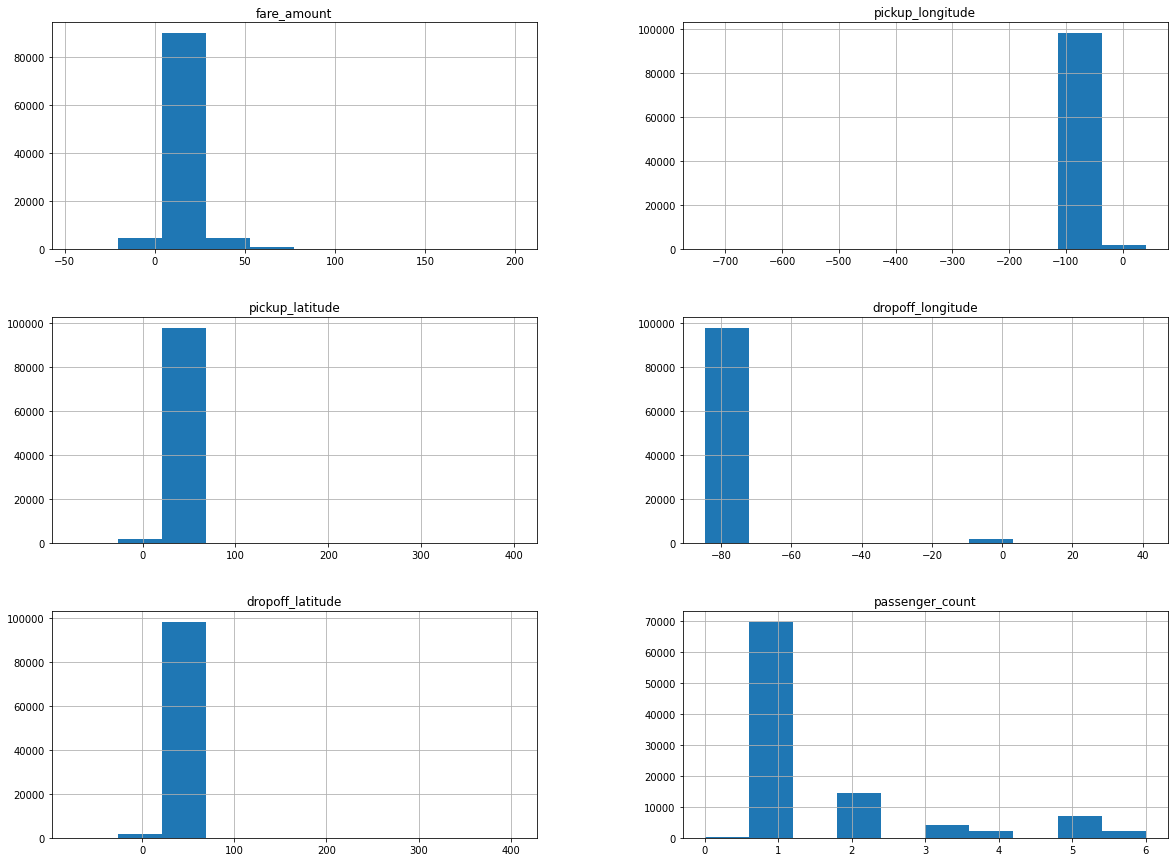

In [14]:
%matplotlib inline
train_df.hist(figsize=(20,15))
plt.show()

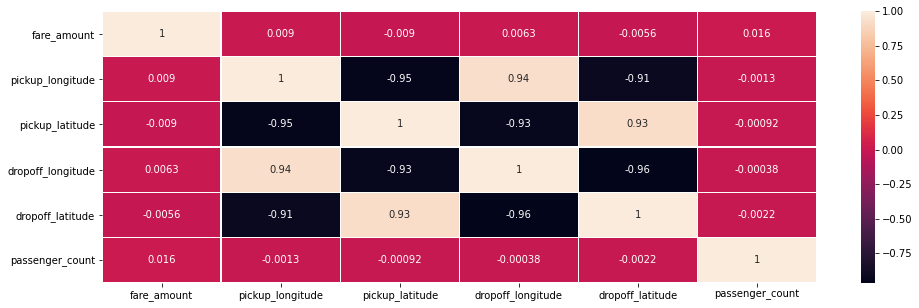

In [15]:
corr_matrix = train_df.corr()
plt.figure(figsize = (16,5))

sns.heatmap(corr_matrix,
            annot=True,
            linewidths=.5)

## Data engineering

Issues that affect taxi fares according to investopedia are as follows:
***
* Yellow cabs have regulated fares to and from the Newark International and John F. Kennedy International airports. For trips between Newark International Airport and New York City, the price is the regular metered fare, plus tolls. For trips between John F. Kennedy International Airport and Manhattan, it is a flat fare. The regular metered fare applies to all trips to and from LaGuardia International Airport.
***
1. Calculate the [Manhattan distance](https://www.sciencedirect.com/topics/computer-science/manhattan-distance) between pick up and drop off points. this is mainly because the Euclidean distance only looks for the shortest path etween two points where as the Manhattan distance was engineered specifically for the grid system like the one at hand.
2. Calculate the distance from each airports for either departure or arrival.
  1. [Newark International Airport](https://www.google.com/maps?client=firefox-b-d&sxsrf=ALeKk00u4W85sTWaeqEF2sopZPLeT8pW4A:1610458245182&q=newark+international+coordinates&gs_lcp=CgZwc3ktYWIQAxgAMgUIIRCgATIFCCEQoAE6BAgAEEc6EAguEMcBEK8BEMkDEEMQkwI6BAgAEEM6AggAOggILhDHARCvAToFCAAQyQM6BggAEBYQHjoHCCEQChCgAToECCEQFVCu0gJY4O0CYL31AmgAcAJ4AIABkQOIAZoVkgEHMi02LjIuMZgBAKABAaoBB2d3cy13aXrIAQjAAQE&um=1&ie=UTF-8&sa=X&ved=2ahUKEwiT-L_UwJbuAhXbiVwKHfxiCAAQ_AUoAXoECAgQAw) 40.6895° N, 74.1745° W
  2. [John F. Kennedy International Airport](https://www.google.com/maps?client=firefox-b-d&sxsrf=ALeKk03Lebh9DX88OXUBXYG3qP3KLMajbg:1610458294397&q=John+F.+Kennedy+International+coordinates&gs_lcp=CgZwc3ktYWIQAzoECAAQR1DU4ApY1OAKYP_nCmgAcAJ4AIAB6QOIAekDkgEDNC0xmAEAoAECoAEBqgEHZ3dzLXdpesgBCMABAQ&uact=5&um=1&ie=UTF-8&sa=X&ved=2ahUKEwiumfrJwZbuAhXDiFwKHR-uB2sQ_AUoAXoECBoQAw) 40.6413° N, 73.7781° W
3. Decompose `pickup_datetime` into its year, month, date and hour components. Futher extract the date of the week

In [16]:
def manhattan_vector(df):
    """
    Function to calculate the Manhattan vector
    Please note that due to bias in SA such that its more expensive to drive to Sandton that around Germiston, I will assume 
    such bias is universal and not calculate the true Manhattan distance, instead leace the components thereof.
    """
    df['logitude_difference'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['lottitude_difference'] = (df.dropoff_latitude - df.pickup_latitude).abs()

manhattan_vector(train_df)
manhattan_vector(test_df)

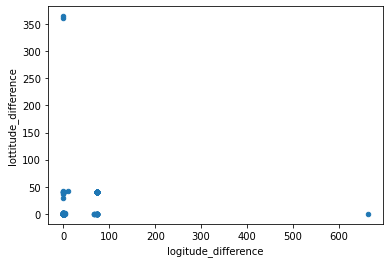

In [17]:
train_df.plot.scatter('logitude_difference', 'lottitude_difference')

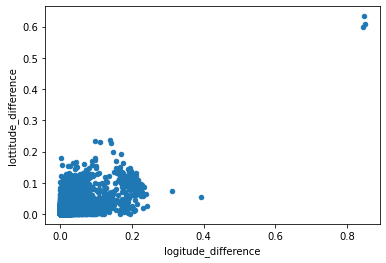

In [18]:
test_df.plot.scatter('logitude_difference', 'lottitude_difference')

* Some serios standardization will be required here

> It is also woth noting that outliers are possible due to the location of the taxi rides as much as Sandton will be more exponsing than Pretorian rides.

* [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) will be used to calculate the distance from each airport.

* * For more details on the algoritm [click me](https://www.kite.com/python/answers/how-to-find-the-distance-between-two-lat-long-coordinates-in-python) 

In [19]:
R = 6373.0

lat1 =np.asarray(np.radians(train_df['pickup_latitude']))
lon1 = np.asarray(np.radians(train_df['pickup_longitude']))
lat2 = np.asarray(np.radians(train_df['dropoff_latitude']))
lon2 = np.asarray(np.radians(train_df['dropoff_longitude']))

lat3=np.zeros(len(train_df))+np.radians(40.6413111)
lon3=np.zeros(len(train_df))+np.radians(-73.7781391)

dlon_pickup = lon3 - lon1
dlat_pickup = lat3 - lat1

d_lon_dropoff=lon3 -lon2
d_lat_dropoff=lat3-lat2

a1 = np.sin(dlat_pickup/2)**2 + np.cos(lat1) * np.cos(lat3) * np.sin(dlon_pickup/ 2)**2
c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1 - a1))
distance1 = R * c1
train_df['Pickup_Distance_airport']=np.asarray(distance1)

a2=np.sin(d_lat_dropoff/2)**2 + np.cos(lat2) * np.cos(lat3) * np.sin(d_lon_dropoff/ 2)**2
c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1 - a2))
distance2 = R * c2

    
train_df['Dropoff_Distance_airport']=np.asarray(distance2)

In [20]:
lat1 =np.asarray(np.radians(test_df['pickup_latitude']))
lon1 = np.asarray(np.radians(test_df['pickup_longitude']))
lat2 = np.asarray(np.radians(test_df['dropoff_latitude']))
lon2 = np.asarray(np.radians(test_df['dropoff_longitude']))

lat3=np.zeros(len(test_df))+np.radians(40.6413111)
lon3=np.zeros(len(test_df))+np.radians(-73.7781391)

dlon_pickup = lon3 - lon1
dlat_pickup = lat3 - lat1
d_lon_dropoff=lon3 -lon2
d_lat_dropoff=lat3-lat2
a1 = np.sin(dlat_pickup/2)**2 + np.cos(lat1) * np.cos(lat3) * np.sin(dlon_pickup/ 2)**2
c1 = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1 - a1))
distance1 = R * c1
test_df['Pickup_Distance_airport']=np.asarray(distance1)*0.621

a2=np.sin(d_lat_dropoff/2)**2 + np.cos(lat2) * np.cos(lat3) * np.sin(d_lon_dropoff/ 2)**2
c2 = 2 * np.arctan2(np.sqrt(a2), np.sqrt(1 - a2))
distance2 = R * c2

    
test_df['Dropoff_Distance_airport']=np.asarray(distance2)*0.621

In [21]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,logitude_difference,lottitude_difference,Pickup_Distance_airport,Dropoff_Distance_airport
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,10.504844,9.538175
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,21.526406,23.075107
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,21.810508,21.694306
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,20.372659,22.195713
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,21.334291,21.853756


In [22]:
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,logitude_difference,lottitude_difference,Pickup_Distance_airport,Dropoff_Distance_airport
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,0.008110,0.019970,13.268494,12.787047
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,0.012024,0.019817,12.191063,13.393626
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,0.002870,0.005121,13.124241,12.798891
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,0.009288,0.016172,13.760833,13.479426
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,0.022519,0.045348,14.210816,13.121913


#### Fixing the pickup_datetime

In [23]:
train_df.pickup_datetime = train_df.pickup_datetime.str.slice(0,16)
test_df.pickup_datetime = test_df.pickup_datetime.str.slice(0,16)

train_df.pickup_datetime = pd.to_datetime(train_df.pickup_datetime, format='%Y-%m-%d %H:%M')
test_df.pickup_datetime = pd.to_datetime(test_df.pickup_datetime, format='%Y-%m-%d %H:%M')

In [24]:
def date_extractor(df):
  df['year'] = pd.DatetimeIndex(df['pickup_datetime']).year
  df['month'] = pd.DatetimeIndex(df['pickup_datetime']).month
  df['day'] = pd.DatetimeIndex(df['pickup_datetime']).day
  df['hour'] = pd.DatetimeIndex(df['pickup_datetime']).hour
  df['date'] = pd.DatetimeIndex(df['pickup_datetime']).date

date_extractor(train_df)
date_extractor(test_df)

In [25]:
def extract_weedkay(df):
  df['weekday'] = pd.to_datetime(df.pickup_datetime).dt.dayofweek

extract_weedkay(train_df)
extract_weedkay(test_df)

In [26]:
train_df['weekday'].replace(to_replace=[i for i in range(0,7)],
                            value=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                              inplace=True)
test_df['weekday'].replace(to_replace=[i for i in range(0,7)],
                              value=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                              inplace=True)

In [27]:
train_one_hot=pd.get_dummies(train_df['weekday'])
test_one_hot=pd.get_dummies(test_df['weekday'])
train_df=pd.concat([train_df,train_one_hot],axis=1)
test_df=pd.concat([test_df,test_one_hot],axis=1)

In [28]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,logitude_difference,lottitude_difference,Pickup_Distance_airport,Dropoff_Distance_airport,year,month,day,hour,date,weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:00,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,10.504844,9.538175,2009,6,15,17,2009-06-15,Monday,0,1,0,0,0,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:00,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,21.526406,23.075107,2010,1,5,16,2010-01-05,Tuesday,0,0,0,0,0,1,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,21.810508,21.694306,2011,8,18,0,2011-08-18,Thursday,0,0,0,0,1,0,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:00,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,20.372659,22.195713,2012,4,21,4,2012-04-21,Saturday,0,0,1,0,0,0,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,21.334291,21.853756,2010,3,9,7,2010-03-09,Tuesday,0,0,0,0,0,1,0


In [29]:
train_df.drop(['weekday', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'date'], axis=1, inplace=True)
test_df.drop(['weekday', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'date'], axis=1, inplace=True)

In [30]:
y = train_df['fare_amount']
train_df.drop(['key','fare_amount'], axis=1, inplace=True)

## Scaling the data

In [31]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(train_df.astype(np.float64))

In [32]:
X_train_scaled

array([[-0.518, -0.042, -0.038, ..., -0.419, -0.402, -0.413],
       [-0.518, -0.033, -0.011, ..., -0.419,  2.489, -0.413],
       [ 0.251, -0.04 , -0.037, ...,  2.386, -0.402, -0.413],
       ...,
       [-0.518, -0.041, -0.041, ...,  2.386, -0.402, -0.413],
       [ 1.789, -0.043, -0.037, ..., -0.419, -0.402, -0.413],
       [-0.518, -0.041, -0.034, ..., -0.419,  2.489, -0.413]])

In [33]:
scaled_features_df = pd.DataFrame(X_train_scaled, columns=train_df.columns)
scaled_features_df.head()

,passenger_count,logitude_difference,lottitude_difference,Pickup_Distance_airport,Dropoff_Distance_airport,year,month,day,hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,-0.518258,-0.042038,-0.037744,-0.149976,-0.150538,-1.470457,-0.075707,-0.076550,0.538601,-0.425523,2.592339,-0.424703,-0.386453,-0.419145,-0.401796,-0.41344
1,-0.518258,-0.032933,-0.011191,-0.141022,-0.139518,-0.934555,-1.524750,-1.228944,0.384929,-0.425523,-0.385752,-0.424703,-0.386453,-0.419145,2.488824,-0.41344
2,0.250876,-0.040487,-0.037027,-0.140791,-0.140642,-0.398652,0.503911,0.269168,-2.073809,-0.425523,-0.385752,-0.424703,-0.386453,2.385812,-0.401796,-0.41344
3,-0.518258,-0.041574,-0.030894,-0.141959,-0.140233,0.137250,-0.655324,0.614886,-1.459125,-0.425523,-0.385752,2.354586,-0.386453,-0.419145,-0.401796,-0.41344
4,-0.518258,-0.039703,-0.034854,-0.141178,-0.140512,-0.934555,-0.945133,-0.767986,-0.998111,-0.425523,-0.385752,-0.424703,-0.386453,-0.419145,2.488824,-0.41344


In [34]:
scaled_features_df.head()

,passenger_count,logitude_difference,lottitude_difference,Pickup_Distance_airport,Dropoff_Distance_airport,year,month,day,hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,-0.518258,-0.042038,-0.037744,-0.149976,-0.150538,-1.470457,-0.075707,-0.076550,0.538601,-0.425523,2.592339,-0.424703,-0.386453,-0.419145,-0.401796,-0.41344
1,-0.518258,-0.032933,-0.011191,-0.141022,-0.139518,-0.934555,-1.524750,-1.228944,0.384929,-0.425523,-0.385752,-0.424703,-0.386453,-0.419145,2.488824,-0.41344
2,0.250876,-0.040487,-0.037027,-0.140791,-0.140642,-0.398652,0.503911,0.269168,-2.073809,-0.425523,-0.385752,-0.424703,-0.386453,2.385812,-0.401796,-0.41344
3,-0.518258,-0.041574,-0.030894,-0.141959,-0.140233,0.137250,-0.655324,0.614886,-1.459125,-0.425523,-0.385752,2.354586,-0.386453,-0.419145,-0.401796,-0.41344
4,-0.518258,-0.039703,-0.034854,-0.141178,-0.140512,-0.934555,-0.945133,-0.767986,-0.998111,-0.425523,-0.385752,-0.424703,-0.386453,-0.419145,2.488824,-0.41344


## Now into splitting and getting the data ready for model fitting

In [35]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features_df, y, test_size=0.01)

### Linear regression

In [36]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

lr_predictions = lr_reg.predict(X_test)

In [37]:
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions)
print("MAE:", lr_mae)
print("MSE:", np.sqrt(lr_mse))

MAE: 5.5445924012993455
MSE: 8.46163795201728


### Decesion tree

In [39]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

tree_predictions = tree_reg.predict(X_test)

tree_mae = mean_absolute_error(y_test, tree_predictions)
tree_mse = mean_squared_error(y_test, tree_predictions)

print("MAE:", tree_mae)
print("MSE:", np.sqrt(tree_mse))

MAE: 3.05417
MSE: 6.610615243681938


### Better Evaluation Using Cross-Validation

In [40]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-tree_scores)